**Student Name**: Karol Ziolo

**Student ID**: 20224449

# Lab 5: Temporal Difference Methods

### Instructions: **TODO** tags
In this lab, you will implement Temporal Difference methods. You will first have to implement the algorithms, then study and compare them:
1. **Policy Evaluation**: provided the same arbitrary policy $\pi$ from the previous lab, compute its value function $v_\pi$ using TD.
2. **SARSA**: implement SARSA, i.e. TD Control, to find an optimal soft policy, using an $\epsilon$-greedy policy.
3. **QLearning**: implement QLearning and Double Q Learning.
4. **Comparison**: run all algorithms for multiple seeds and compare the results 
5. **Playground**: Study the hyperparameters of QLearning 

As usual, please *read* and *run* the notebook chronologically, and fill in the **TODO**s as you encounter them.
* <span style="color:blue"> Blue **TODOs** </span> means you have to implement the TODOs in the code.
* <span style="color:red"> Red **TODOs** </span> means you have to submit an explanation (of graph/results/theory).

At each section, <span style="color:green"> (xx points) </span> indicates the number of points of the entire section (labs are graded out of 10).

### Environment
The env is the same 4room env from last time.

In [1]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals
import numpy as np
import gym
from gym import spaces
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from matplotlib import cm
import random
from copy import copy

In [6]:
class FourRoomsEnv(gym.Env):
    """ Small Gridworld environment with 4 rooms.
    Starting up left, goal in lower-right.
    The main challenge is that the reward is sparse (1_goal)
        """
    def __init__(self, explo_starts=False, max_steps=None):
        self.roomsize = 5
        self.height = 2*self.roomsize +1 # +1 is obstacle width
        self.width = self.height
        half = self.width // 2 # shortcut
        quarter = half // 2 # shortcut
        self.gamma = 0.9
        self.t = 0
        self.max_steps = max_steps
        self.explo_starts = explo_starts
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Tuple((
                spaces.Discrete(self.height),
                spaces.Discrete(self.width)
                ))
        self.shapes = ((11,11),4)

        self.moves = {
                0: (-1, 0),  # up
                1: (0, 1),   # right
                2: (1, 0),   # down
                3: (0, -1),  # left
                }
        self.moves_to_str = {
                0: u'↑',
                1: u'→',
                2: u'↓',
                3: u'←',
                }
        
        self.terminal = (self.height-1,self.width-1) # terminal state
        horizontal  = [(i, half) for i in range(self.width)]
        vertical    = [(half, i) for i in range(self.height)]
        self.obstacles = horizontal + vertical
        # now opening the 4 passages
        for state in [(quarter,half), (half,quarter), (half,self.height-quarter), (self.height-quarter,half)]:
            self.obstacles.remove(state)
        self.start = (0,0)
        # begin in start state
        self.reset()

    def reset(self):
        if self.max_steps is not None:
            self.t = 0
        if self.explo_starts:
            while True:
                s = self.observation_space.sample()
                if s not in self.obstacles + [self.terminal]:
                    break
            self.s = s
            #print("Random Start at S={}".format(s))
                
        else:
            self.s = self.start
        return self.s

    def step(self, action):
        """ Moves the agent in the action direction."""
        # Next, moving according to action
        x, y = self.moves[action]
        if (self.s[0]+x, self.s[1]+y) not in self.obstacles:
            # move is allowed
            self.s = self.s[0] + x, self.s[1] + y

            # Finally, setting the agent back into the grid if fallen out
            self.s = (max(0, self.s[0]), max(0, self.s[1]))
            self.s = (min(self.s[0], self.height - 1),
                      min(self.s[1], self.width - 1))

        self.t += 1
        done_goal = (self.s == self.terminal)
        done = done_goal
        if self.max_steps is not None and self.t == self.max_steps:
            done = True
            self.t = 0
        return self.s, int(done_goal), done, {}
    
    def is_terminal(self, state):
        return state == self.terminal
    
    def p(self, state, action):
        assert not self.is_terminal(state)
        self.s = state
        next_state, reward, done, info = self.step(action)
        return {(next_state, reward): 1}
    
    def states(self):
        ss = []
        for i in range(self.height):
            for j in range(self.width):
                if (i,j) not in self.obstacles:
                    ss.append((i,j))
        return ss 
    
    def plot_values_policy(self, values, policy, plot_all_policy=False, cbar=True):
        """ Visualizes a policy and value function given an agent with V and policy."""
        fig, ax = plt.subplots()
        values[tuple(zip(*self.obstacles))] = None # -1
        cmap = copy(cm.get_cmap("RdYlGn"))
        # modify colormap
        l = np.array([cmap(i) for i in range(cmap.N)]).T
        l[0:2] = np.clip(l[0:2], 0,0.9)
        l[2] = np.clip(l[2], 0,0.25)
        l = l.T
        my_cmap = matplotlib.colors.ListedColormap(l, name = 'nani')
        my_cmap.set_bad('black')

        im = ax.imshow(values, cmap=my_cmap)
        for i in range(self.height):
            for j in range(self.width):
                s = (i,j)
                if s not in self.obstacles:
                    t = self.moves_to_str[policy[s]] if not self.is_terminal(s) \
                                                        and ((values[s] != 0) or (plot_all_policy)) else ""
                    text = ax.text(j, i, t,
                                   ha="center", va="center", color="w", fontsize=15)

        ax.set_title("Value function and Policy visualization")
        fig.tight_layout()
        if cbar:
            plt.colorbar(im)
        plt.show()

## 1. <span style="color:green"> (2 points) </span> Policy Evaluation

### 1.1 Defining and visualizing the policy
We are using the same Env and policy as the MC lab:

/var/folders/cl/rrx_9t192b9328xy7nz8dc580000gn/T/ipykernel_20729/2117137865.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


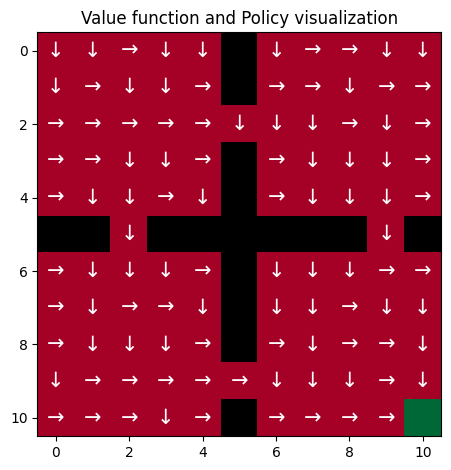

In [3]:
# Defining the environment
np.random.seed(54)
env = FourRoomsEnv()
# Defining the policy
pi = {s:np.random.choice([1,2]) for s in env.states()}
# Visualizing the environment and policy
zero_values = np.zeros(env.shapes[0])
zero_values[env.terminal] = 1
env.plot_values_policy(zero_values, pi, plot_all_policy = True, cbar=False)
np.random.seed(None)

### 1.2. DP Policy Evaluation
Last time, you had to implement the DP solution for it. No need to redo it this time, here's the value function $v_\pi$ of our policy $\pi$ for all the states:

In [7]:
class DP_PolicyEvaluation():
    def __init__(self, mdp):
        self.mdp = mdp
        self.gamma = self.mdp.gamma
        self.V = np.zeros(self.mdp.shapes[0])
        
    def run(self, pi, delta):
        sweeps = 0
        while True:
            norm = 0
            sweeps += 1
            for s in self.mdp.states():
                if not self.mdp.is_terminal(s):
                    v = self.V[s]
                    a = pi[s]
                    psa = self.mdp.p(s,a)
                    self.V[s] = sum([psa[s_,r]*(r+self.gamma*self.V[s_]) for s_,r in psa.keys()])
                    norm = max(norm, abs(v-self.V[s]))
            # exit condition
            if norm < delta:
                print("Exiting PEval through norm={:7f} < {:7f}=delta after {} sweeps".format(norm, delta, sweeps))
                break
        

/var/folders/cl/rrx_9t192b9328xy7nz8dc580000gn/T/ipykernel_20729/2117137865.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


Exiting PEval through norm=0.000000 < 0.001000=delta after 15 sweeps


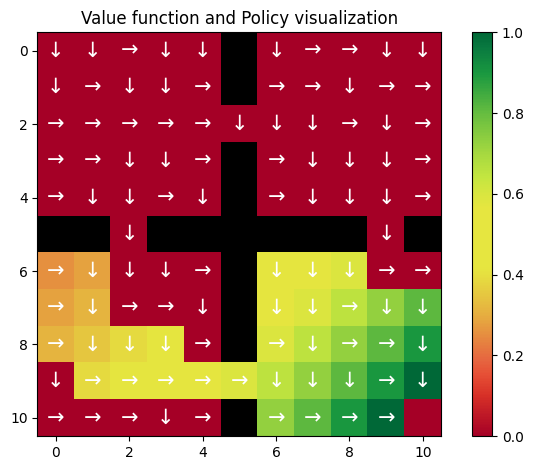

In [5]:
agent_dp = DP_PolicyEvaluation(env)
agent_dp.run(pi, delta=1e-3)
env.plot_values_policy(agent_dp.V, pi, plot_all_policy = True)

### 1.3.  <span style="color:blue"> **TODO** </span> TD Policy Evaluation

We will now find $v_\pi$ simply by interacting with the environment, using Temporal Difference Learning.

- <span style="color:red"> **TODO** </span>: **Remind** the main difference between Monte Carlo methods and Temporal Difference Learning. <br/> 
The main difference between Monte Carlo and Temporal Difference Learning is that we must store all states, actions and their rewards through the whole episode to calculate our estimates. However, in TD methods we require only one timestamp to update them. In other words, TD methods are naturally implemented in an online and incremental fashion.
- <span style="color:blue"> **TODO** </span>: **Implement** TD Policy Evaluation provided the policy $\pi$ we have already evaluated.

In [8]:
class TDPolicyEval():
    """ Given a policy, uses that policy to act in the environment.
    Learns its V value.
    """
    def __init__(self, env_shapes, pi, epsilon=0.1, gamma=0.9, alpha=0.1, **kwargs):
        if env_shapes is not None: # otherwise, bandits
            self.input_shape, self.n_actions = env_shapes
        self.gamma = gamma
        self.epsilon = epsilon
        self.pi = pi
        self.alpha = alpha
        self.V = np.zeros(self.input_shape)
        self.reset()

    def reset(self):
        pass
        
    def act(self, s):
        # TODO
        return self.pi[s]
        raise NotImplementedError("act method of the TDPolicyEval Agent")

    def learn(self, s, a, r, s_, d=False):
        # TODO
        self.V[s] = self.V[s] + self.alpha * (r + self.gamma * self.V[s_] - self.V[s])
        # raise NotImplementedError("learn method of the TDPolicyEval Agent")

In [9]:
# Learning and visualization. Nothing to do here.
def learn_v_pi(agent, env, n_episodes):
    evaluations_history = []
    agent.reset()
    first = True
    # Training phase
    for ep in range(n_episodes):
        s = env.reset()
        while True: # step limit implemented in Env
            action = agent.act(s) # must be = pi[s]
            s_, reward, done, info = env.step(action)
            agent.learn(s, action, reward, s_, done)
            if done:
                break
            s = s_
        if first and np.any(agent.V != 0):
            print("V visualization after the first rewarding episode observed - episode {}:".format(ep))
            env.plot_values_policy(agent.V, agent.pi, plot_all_policy=True)
            first = False
        if not first and not ep % 200:
            print("V visualization after episode {}:".format(ep))
            env.plot_values_policy(agent.V, agent.pi, plot_all_policy=True)
        
    print("Final V visualization: ")
    env.plot_values_policy(agent.V, agent.pi, plot_all_policy=True)
    env.close()

We're using Exploring Starts as before, because we want to see the Value map for all states.

V visualization after the first rewarding episode observed - episode 0:


/var/folders/cl/rrx_9t192b9328xy7nz8dc580000gn/T/ipykernel_20729/2117137865.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


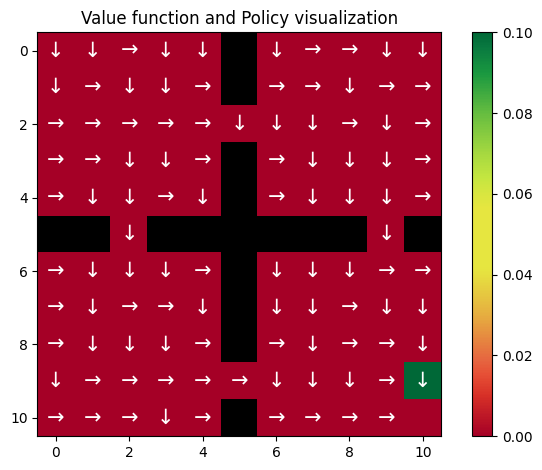

V visualization after episode 0:


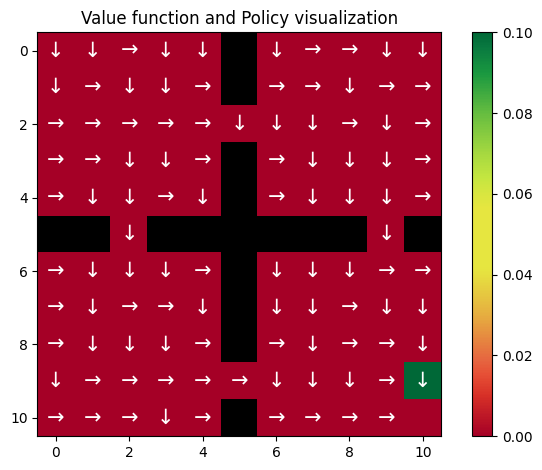

V visualization after episode 200:


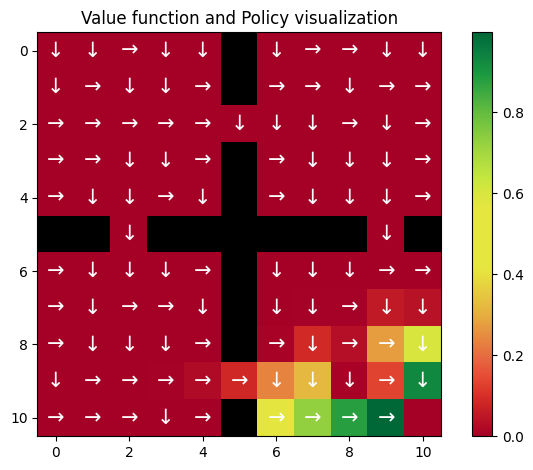

V visualization after episode 400:


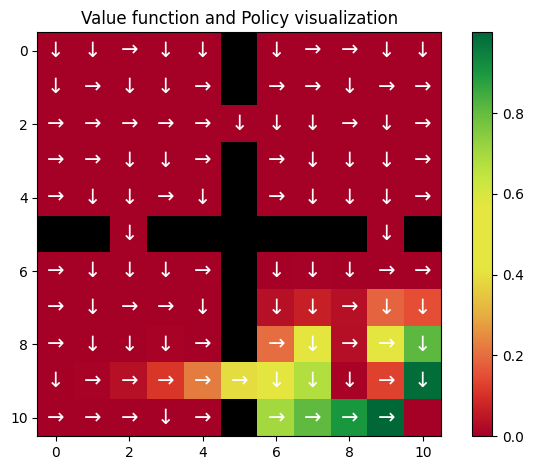

V visualization after episode 600:


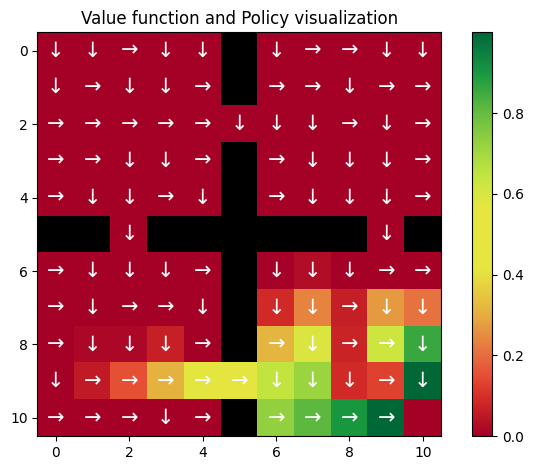

V visualization after episode 800:


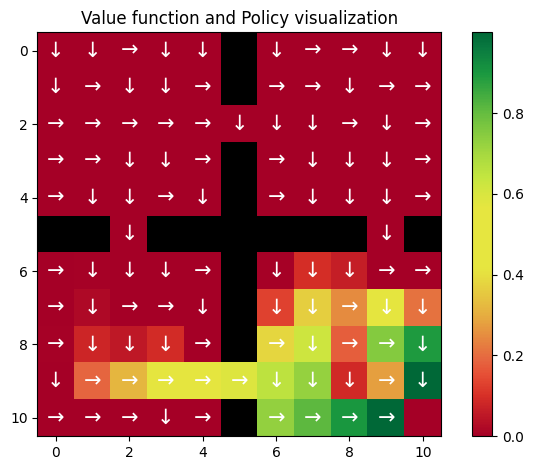

Final V visualization: 


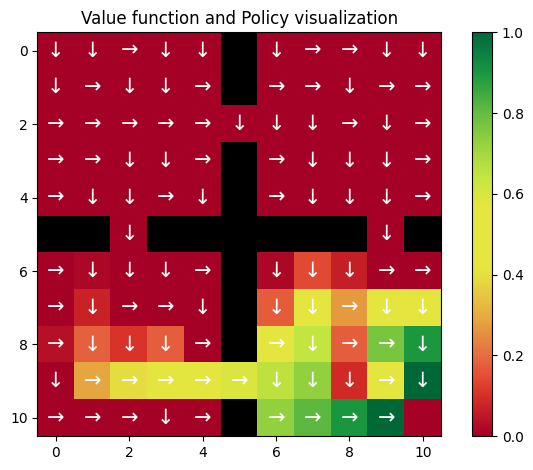

In [114]:
env = FourRoomsEnv(explo_starts=True, max_steps = 50)
d = {
    'env_shapes': env.shapes,
    'epsilon': 0.2,
    'alpha' : 0.1,
    'gamma': env.gamma,
    'pi' : pi
}
agent_td = TDPolicyEval(**d)

learn_v_pi(agent_td, env, 1000)

Reminder, to compare with the DP solution:

/var/folders/cl/rrx_9t192b9328xy7nz8dc580000gn/T/ipykernel_20729/2117137865.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


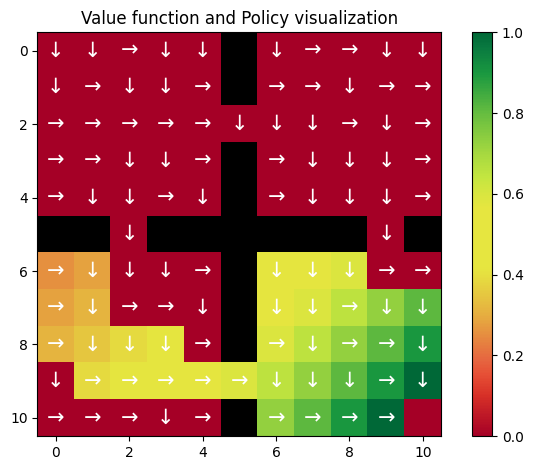

In [9]:
env.plot_values_policy(agent_dp.V, pi, plot_all_policy = True)

<span style="color:red"> **TODO** </span>: As you might notice, DP isn't as fast as was MC in this case. This is due to the very specific problem we're trying to solve, **can you see why**? **What** could we do to take advantage of the situation? If you have an idea, **apply** your changes and show the difference in a cell below.

The TD methods depend on the initial conditions of the lerning parameters. In our case we don't have practically any information from any state rewards or transition probabilities. Therefore, the agent must learn through exploring the environment following policy pi. The pace for estimating $V{\pi}$ depends for instance on the learning rate. However, MC methods collect information through all episode. Thanks to that each update is made using a true sample of what $Q(s,a)$ should be. If we want to speed up the TD method we need to play with learning parameters as shown below.

V visualization after the first rewarding episode observed - episode 0:


/var/folders/cl/rrx_9t192b9328xy7nz8dc580000gn/T/ipykernel_20729/2117137865.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


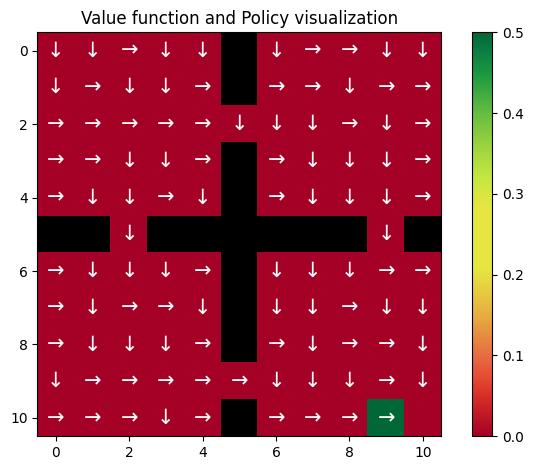

V visualization after episode 0:


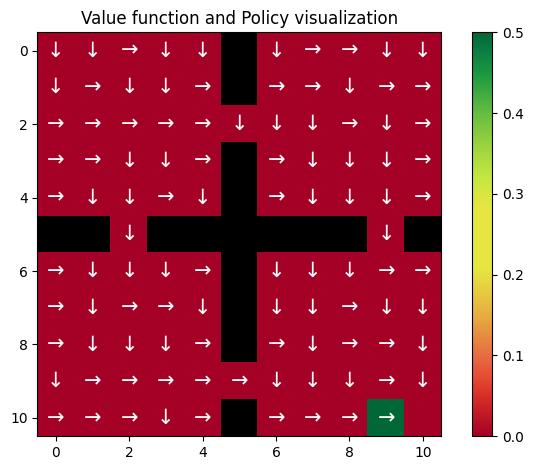

V visualization after episode 200:


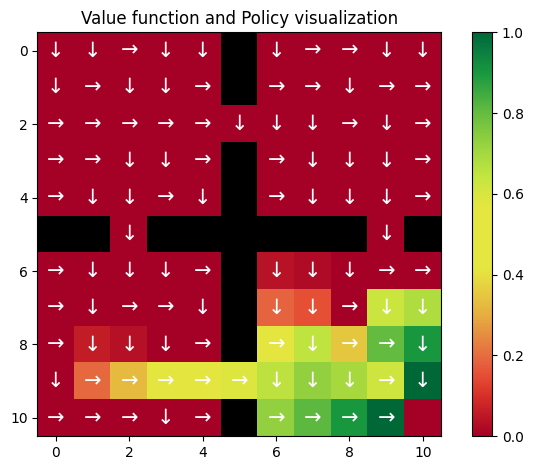

V visualization after episode 400:


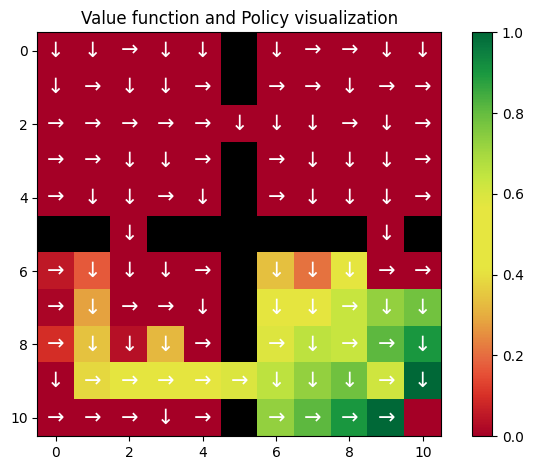

V visualization after episode 600:


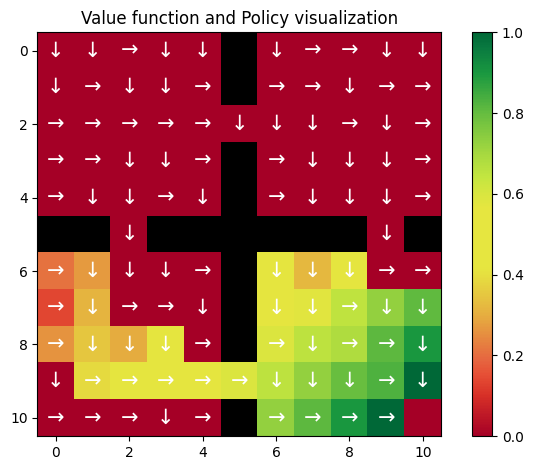

V visualization after episode 800:


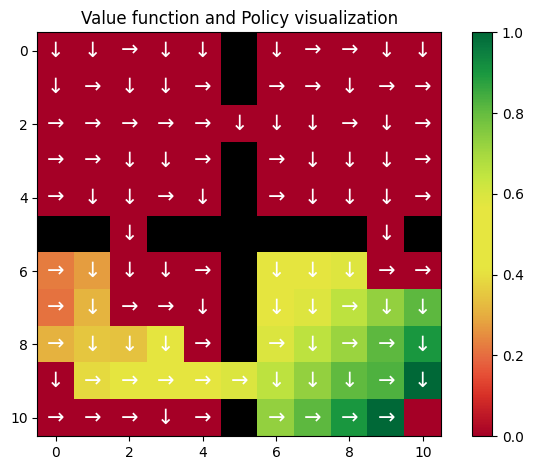

Final V visualization: 


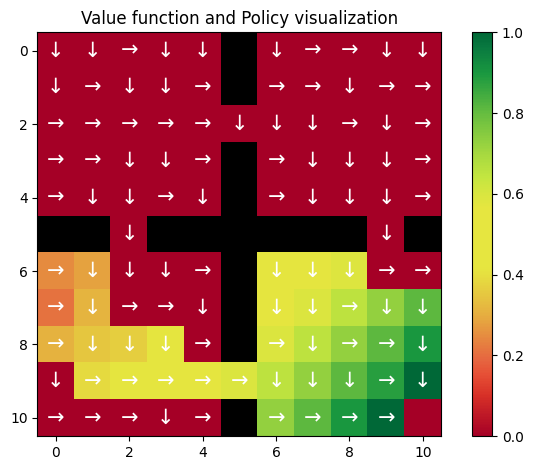

In [116]:
env = FourRoomsEnv(explo_starts=True, max_steps = 50)
d = {
    'env_shapes': env.shapes,
    'epsilon': 0.2,
    'alpha' : 0.5,
    'gamma': env.gamma,
    'pi' : pi
}
agent_td = TDPolicyEval(**d)

learn_v_pi(agent_td, env, 1000)

## 2. <span style="color:green"> (2 points) </span> <span style="color:blue"> **TODO** </span> SARSA
SARSA is the Control version of TD-learning. 

- <span style="color:red"> **TODO** </span> **Remind** how to get from TD to SARSA, and the theoretical justification behind this.<br/> 
In SARSA we want to learn an action-value function instead of state-value function and also we want to focus on the transtions from state-action pair to state-action pair. The theoretical justification behind this is that we still work with Markov chains with a reward process. 
- <span style="color:blue"> **TODO** </span> **Implement** SARSA.

In [10]:
# Nothing to do in this cell.
def allmax(a):
    """ Returns all occurences of the max """
    if len(a) == 0:
        return []
    all_ = [0]
    max_ = a[0]
    for i in range(1, len(a)):
        if a[i] > max_:
            all_ = [i]
            max_ = a[i]
        elif a[i] == max_:
            all_.append(i)
    return all_

def my_argmax(v):
    """ Breaks ties randomly. """
    return random.choice(allmax(v))

In [11]:
class SARSA():
    """ Tabular method that keeps the Q-values of all the possible
    state-action pairs; applies TD for Policy Evaluation. 
    On-Policy algo using epsilon-greedy.
    """
    def __init__(self, env_shapes, epsilon=0.1, gamma=0.9, alpha=.1, **kwargs):
        if env_shapes is not None: # otherwise, bandits
            self.input_shape, self.n_actions = env_shapes
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.Q = np.zeros((*self.input_shape, self.n_actions))
        # TODO, if you have stuff to add

    def reset(self):
        # TODO
        pass
        # raise NotImplementedError("reset method of the SARSA Agent")

    def act(self, s):
        if np.random.uniform(0,1) < self.epsilon:
            a = np.random.choice(range(self.n_actions))
        else:
            a = my_argmax(self.Q[s])
        return a
        raise NotImplementedError("act method of the SARSA Agent")

    def learn(self, s, a, r, s_, d=False):
        # TODO
        a_ = self.act(s_)
        self.Q[s][a] += self.alpha * (r + self.gamma * self.Q[s_][a_] - self.Q[s][a])
        # raise NotImplementedError("learn method of the SARSA Agent")

In [12]:
def view_train_agent(agent, env, n_episodes, plot=True, out_reward=False):
    """ Trains an agent on an env for a given amount of steps.
    If out_reward=False, returns the steps_history of the agent, i.e. number of steps each episode took.
    If out_reward=True, returns the running reward."""
    view = [0,1,3,5,10,100,500]
    agent.reset()
    # Training phase
    returns_history = np.empty(n_episodes) # all cumulative rewards during training
    steps_history = np.empty(n_episodes)
    for ep in range(n_episodes):
        t = 0
        s = env.reset()
        cum_r = 0 # cumulative reward
        while True:
            action = agent.act(s)
            s_, reward, done, info = env.step(action)
            agent.learn(s, action, reward, s_, done)
            cum_r += reward
            if done:
                break
            s = s_
            t += 1
        if plot and ep in view:
            print("Best Q and action after episode {}:".format(ep))
            best_qs = np.max(agent.Q, axis=-1)
            greedy_policy = np.argmax(agent.Q, axis=-1)
            env.plot_values_policy(best_qs, greedy_policy)

        steps_history[ep] = t
        returns_history[ep] = cum_r
        
    if plot:
        print("Final Q and policy:")
        best_qs = np.max(agent.Q, axis=-1)
        greedy_policy = np.argmax(agent.Q, axis=-1)
        env.plot_values_policy(best_qs, greedy_policy)
    env.close()
    if out_reward:
        return returns_history
    else:
        return steps_history

Since there is now stochastic exploration, the episodes will all reach the terminal state, if given enough time. We can remove both the step limit and Exploring Starts.

Best Q and action after episode 0:


/var/folders/cl/rrx_9t192b9328xy7nz8dc580000gn/T/ipykernel_66576/2117137865.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


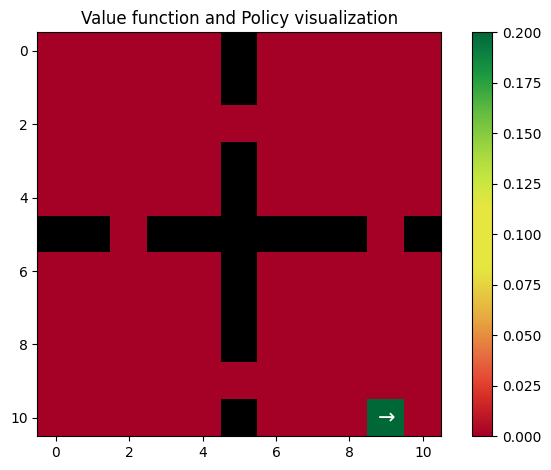

Best Q and action after episode 1:


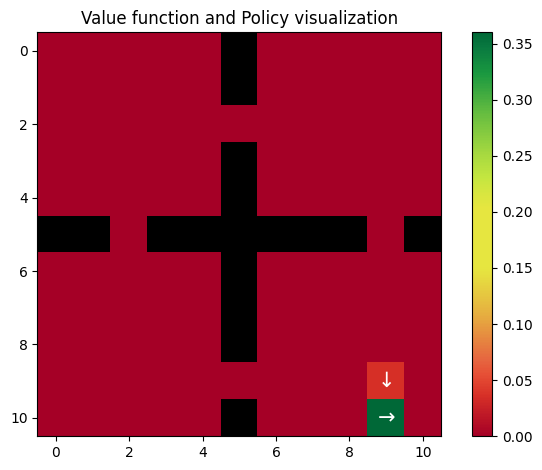

Best Q and action after episode 3:


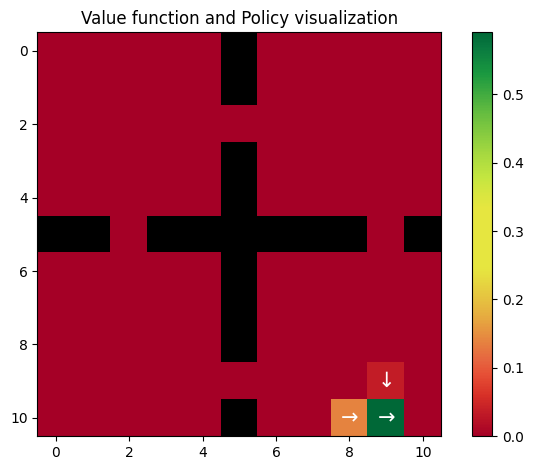

Best Q and action after episode 5:


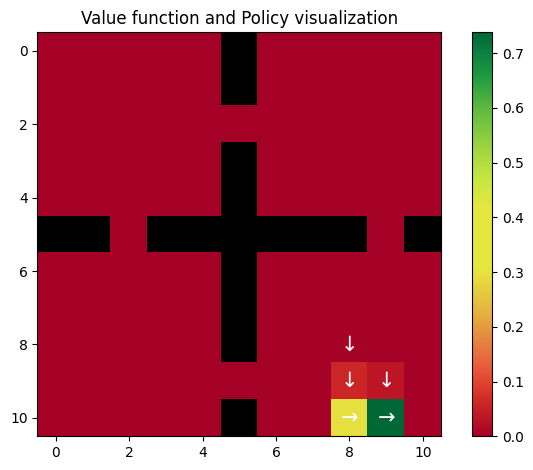

Best Q and action after episode 10:


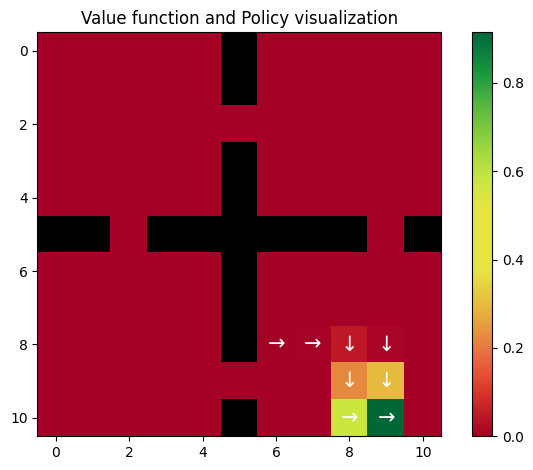

Best Q and action after episode 100:


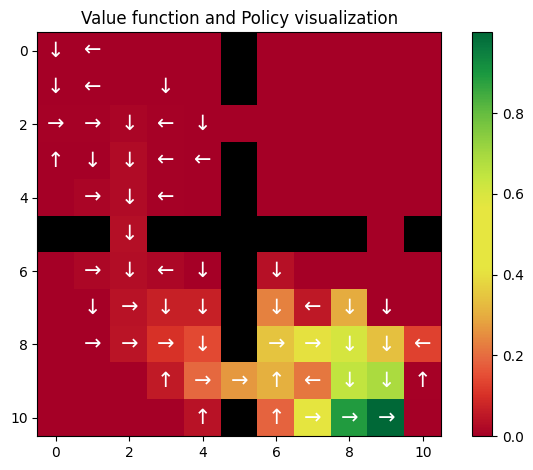

Best Q and action after episode 500:


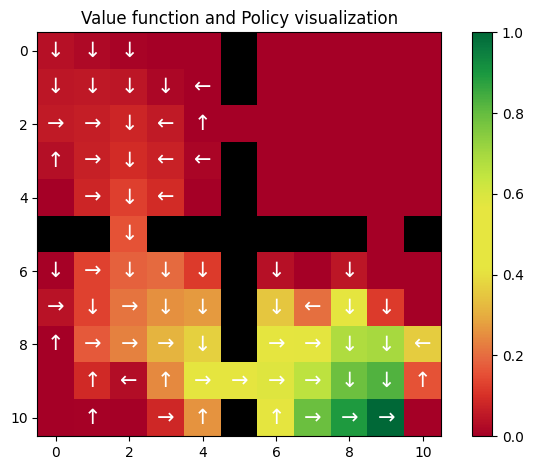

Final Q and policy:


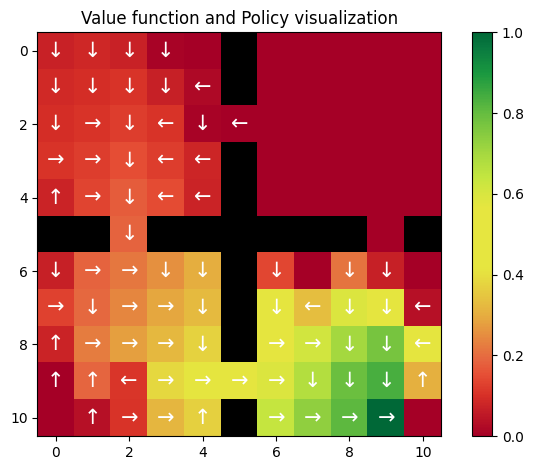

In [20]:
env = FourRoomsEnv()
d = {
    'env_shapes': env.shapes,
    'alpha' : 0.2,
    'epsilon': 0.2,
    'gamma': env.gamma,
    'q0' : 0,
}
agent = SARSA(**d)
perf_sarsa = view_train_agent(agent, env, 2000)

As a reminder, below are the values found by two independ runs of an epsilon-greedy Monte Carlo algorithm.

<table><tr>
<td> <img src="attachment:final_q_MCEG.png" alt="Drawing" style="width: 350px;"/> </td>
<td> <img src="attachment:q_MCEG2.png" alt="Drawing" style="width: 350px;"/> </td>
</tr></table>

<span style="color:red"> **TODO** </span>: **Can** you see a difference in the found policies? **Explain** why this is happening.

We can notice that MC have visited more states than Sarsa. It means that Sarsa learns more efficiently. Additionally, the MC method suffers from high variance. It explores more to obtain practically the same results. The reason behind that is that Sarsa is more exploiting the environment by updating $Q$ values using already known values from the past. However, Monte Carlo is using average returns which leads to bigger variance.

## 3. <span style="color:green"> (2 points) </span> <span style="color:blue"> **TODO** </span> QLearning

### 3.1. <span style="color:blue"> **TODO** </span> Vanilla QLearning

- <span style="color:red"> **TODO** </span> **Explain** the difference in approach between SARSA and QLearning. <br/> 
Sarsa in each step of episode updates action value function using the next action for the state based on the epsilon greedy policy. However, QLearning always uses greedy action for next state.
- <span style="color:blue"> **TODO** </span> **Implement** QLearning.

In [13]:
class QLearning(SARSA):
    # TODO: implement using the formalism from MC and SARSA
    def __init__(self, env_shapes, epsilon=0.1, gamma=0.9, alpha=0.1, **kwargs):
        super().__init__(env_shapes, epsilon, gamma, alpha, **kwargs)
        
    def reset(self):
        pass
    
    def act(self, s):
        return super().act(s)
    
    def learn(self, s, a, r, s_, d=False):
        self.Q[s][a] += self.alpha * (r + self.gamma * np.max(self.Q[s_]) - self.Q[s][a])

    # raise NotImplementedError("QLearning Agent")

Best Q and action after episode 0:


/var/folders/cl/rrx_9t192b9328xy7nz8dc580000gn/T/ipykernel_20729/2117137865.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


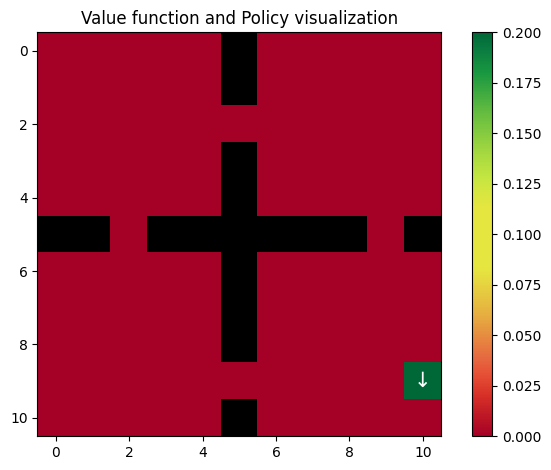

Best Q and action after episode 1:


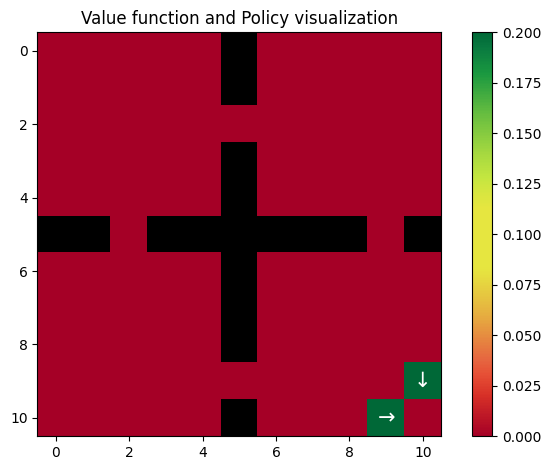

Best Q and action after episode 3:


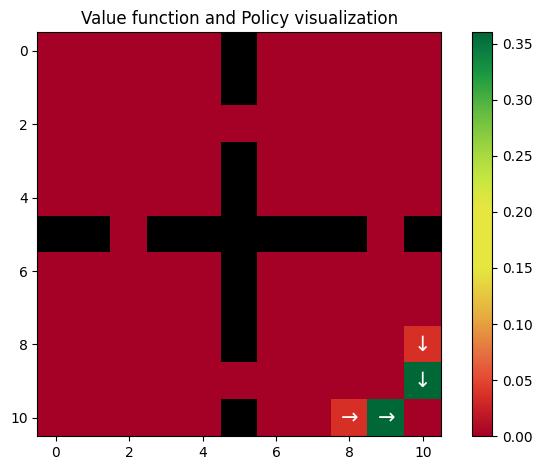

Best Q and action after episode 5:


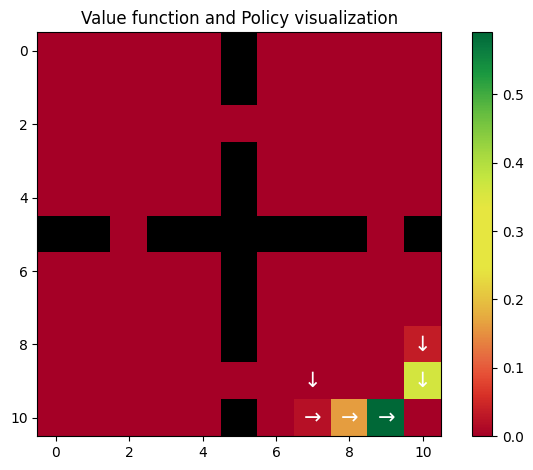

Best Q and action after episode 10:


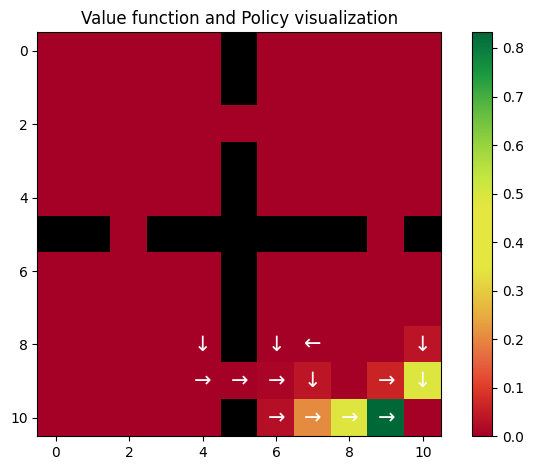

Best Q and action after episode 100:


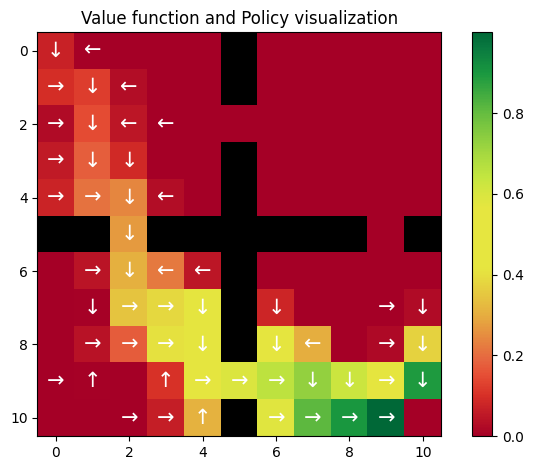

Best Q and action after episode 500:


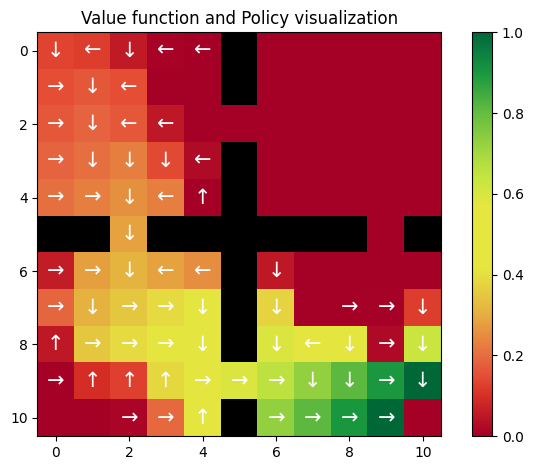

Final Q and policy:


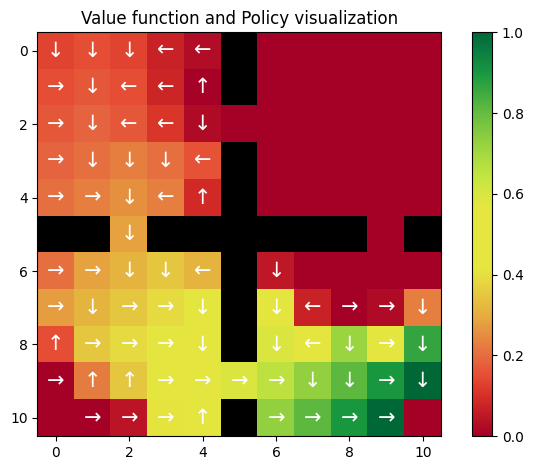

In [118]:
env = FourRoomsEnv()
shapes = (tuple([env.observation_space[i].n for i in range(len(env.observation_space))]), env.action_space.n)
d = {
    'env_shapes': shapes,
    'epsilon': 0.2,
    'alpha' : 0.2,
    'gamma': env.gamma,
}
agent = QLearning(**d)
perf_ql = view_train_agent(agent, env, 2000)

<span style="color:red"> **TODO** </span>: **Interpret** briefly your results.

Here we can notice that that agent explores even less than in case of Sarsa method. This is the reason of choosing greedy action for next state while updating Q values instead of following epsilon greedy policy. If we compare steps between those two algorithms we can notice that QLearning has less branches during learning. Agent focuses more on exploiting the environment. We reduced a randomness in Q updates. These results prove the efficiency of Qlearning method method. It is visible that one room wasn't even explored. 

### 3.2. <span style="color:blue"> **TODO** </span> Double Q Learning
The benefits of Double Q Learning are clearest when using a very simple environment with the following MDP:
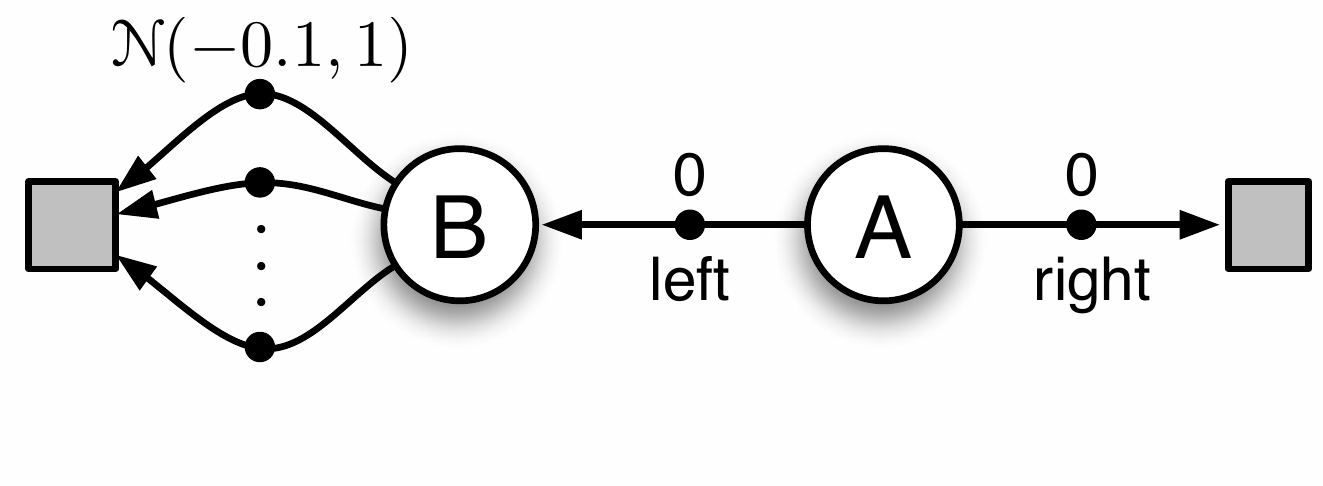

In [14]:
class MaxBiasEnv(gym.Env):
    def __init__(self):
        # We choose arbitrarily the number of actions from B out
        self.n_actions = 10
        self.action_space = spaces.Discrete(self.n_actions)
        self.shapes = ((3,),self.n_actions)
        self.observation_space = spaces.Discrete(3) # A:0, B:1, Terminal: 2
        self.gamma = 0.9
        # begin in start state
        self.reset()

    def reset(self):
        self.s = 1 # A
        return self.s

    def step(self, action):
        """ Moves the agent in the action direction."""
        r = 0
        if self.s == 1: # State A
            # this is kind of lazy programming so that you can use your QLearning agent, but it means there are
            # much more actions from A than necessary.
            self.s += 2*(action%2) - 1 # {left, right}={0,1} -> {-1, 1}
        elif self.s == 0: # State B
            self.s = 2  # any action is terminal
            r = np.random.randn() - 0.1
        # Returns
        done = (self.s==2)
        return self.s, r, done, {}

We will need to run these experiments many times to observe the expected result.

In [15]:
def train_agent_maxbias(agent, env, n_episodes):
    """ Focuses on the amount of correct (right) action from A"""
    agent.reset()
    # Training phase
    right_history = np.empty(n_episodes)
    for ep in range(n_episodes):
        s = env.reset()
        while True:
            action = agent.act(s)
            if s==1: # A
                right_history[ep] = action%2
            s_, reward, done, info = env.step(action)
            agent.learn(s, action, reward, s_, done)
            if done:
                break
            s = s_        
    env.close()
    return right_history
    
def multiple_train_agent_maxbias(agent, env, n_episodes, n_s, out_reward=False):
    perfs = np.empty((n_s, n_episodes))
    for i in range(n_s):
        perfs[i] = train_agent_maxbias(agent, env, n_episodes)
    return np.mean(perfs, 0)

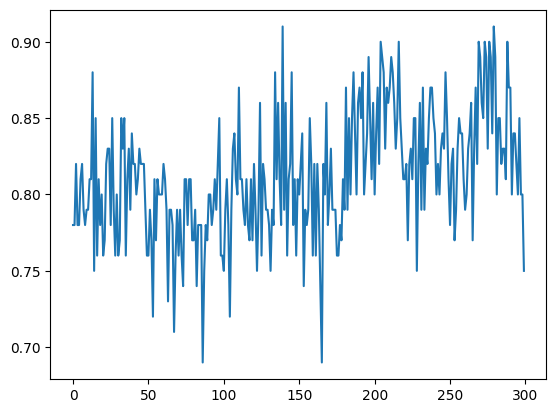

In [21]:
env = MaxBiasEnv()
d["env_shapes"] = env.shapes
agent = QLearning(**d)
perf_ql = multiple_train_agent_maxbias(agent, env, 300, 100)
plt.plot(perf_ql)

- <span style="color:red"> **TODO** </span> **Explain** the problem that QLearning has that DoubleQLearning attempts to solve, as well as the attempted solution.

Double Q-Learning attempts to solve the problem of the maximization bias which occurs when algorithm overestimates action-value estimates. Double QLearning solves that problem by adding second Q matrix. Therefore, we have two action-value functions which are treated symmetrically which reduces maximization bias.
- <span style="color:blue"> **TODO** </span> **Implement** Double Q Learning.

In [23]:
class DoubleQLearning(SARSA):
    # TODO: implement using the formalism from MC and SARSA 
    def __init__(self, env_shapes, epsilon=0.1, gamma=0.9, alpha=0.1, **kwargs):
        super().__init__(env_shapes, epsilon, gamma, alpha, **kwargs)
        self.Q2 = np.zeros((*self.input_shape, self.n_actions))
    
    def act(self, s):
        if np.random.uniform(0,1) < self.epsilon:
            a = np.random.choice(range(self.n_actions))
        else:
            a = my_argmax(self.Q[s] + self.Q2[s])
        return a

    def learn(self, s, a, r, s_, d=False):
        if np.random.uniform(0,1) < 0.5:
            a_ = my_argmax(self.Q[s_])
            self.Q[s][a] += self.alpha * (r + self.gamma * self.Q2[s_][a_]- self.Q[s][a])
        else:
            a_ = my_argmax(self.Q2[s_])
            self.Q2[s][a] += self.alpha * (r + self.gamma * self.Q[s_][a_]- self.Q2[s][a])
        
    # raise NotImplementedError("Double Q Learning Agent")

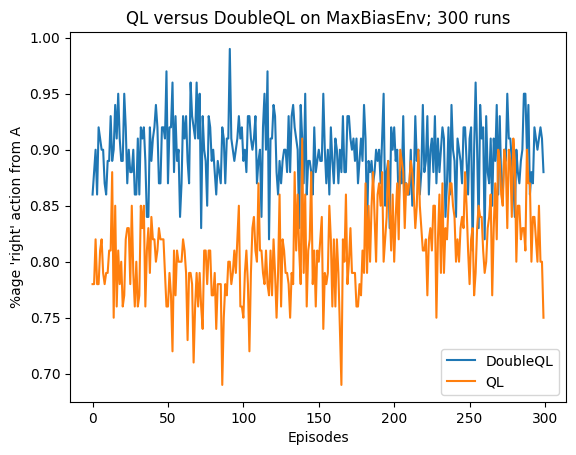

In [24]:
env = MaxBiasEnv()
d["env_shapes"] = env.shapes
agent = DoubleQLearning(**d)
perf_dql = multiple_train_agent_maxbias(agent, env, 300, 100)

# Comaprison plot:
plt.plot(perf_dql, label="DoubleQL")
plt.plot(perf_ql, label="QL")
plt.legend(); plt.title("QL versus DoubleQL on MaxBiasEnv; 300 runs")
plt.xlabel("Episodes"); plt.ylabel("%age 'right' action from A") 
plt.show()

<span style="color:red"> **TODO** </span> **Interpret** your results.

We can notice that percentage of choosing "right" action by Double QLearning is higher than by normal QLearning. It means that this algorithm indeed reduced the problem with overestimation.

## 4. <span style="color:green"> (2 point) </span> <span style="color:red"> **TODO** </span> Windy Environment Comparison 
The 4 Room Environment use until now is conveninent to track and understand how values are updated, but the deterministic setting makes it hard to compare the algorithms in general.

Let's add noise to the environment. To prevent the noise from helping exploration (if it was just some randomness in the actions), we add wind: the agent is sometimes pushed to the right in the upper part of the environment, and to the left in the lower part, as if there were two opposite gusts of wind or big fans.

In this section there will be nothing to implement! Just run the cells and interpret the final results.

In [167]:
class FourRoomsWindyEnv(FourRoomsEnv):    
    def step(self, action):
        """ Moves the agent in the action direction."""
        # Next, moving according to action
        x, y = self.moves[action]                
        # CHANGE: Apply wind. Agent might clip through walls by luck, but it's fine
        if self.s[0] < self.height//2:
            if np.random.rand() < 0.15:
                y += 1
        else:
            if np.random.rand() < 0.15:
                y -= 1
        if (self.s[0]+x, self.s[1]+y) not in self.obstacles:
            # move is allowed

            self.s = self.s[0] + x, self.s[1] + y
        

        # Finally, setting the agent back into the grid if fallen out
        self.s = (max(0, self.s[0]), max(0, self.s[1]))
        self.s = (min(self.s[0], self.height - 1),
                  min(self.s[1], self.width - 1))

        self.t += 1
        done_goal = (self.s == self.terminal)
        done = done_goal
        if self.max_steps is not None and self.t == self.max_steps:
            done = True
            self.t = 0
        return self.s, int(done_goal), done, {}

Now we would like to test all our agents so far on this environment. First, let's reintroduce the On-policy MC agent:

In [168]:
class EGMonteCarlo():
    """ Tabular method that keeps the Q-values of all the possible
    state-action pairs; updates on an episode-wise schedule
    On-Policy version using epsilon-greedy
    """
    def __init__(self, env_shapes, epsilon=0.1, gamma=0.9, **kwargs):
        if env_shapes is not None: # otherwise, bandits
            self.input_shape, self.n_actions = env_shapes
        self.gamma = gamma
        self.epsilon = epsilon
        self.reset()

    def _episodic_reset(self):
        """ Resets the history, G and W variables for another episode """
        self.trajectory = []

    def reset(self):
        self.Q = np.zeros((*self.input_shape, self.n_actions)) # Q value estimates
        self.C = np.zeros((*self.input_shape, self.n_actions))
        self._episodic_reset()

    def act(self, s):
        """ Epsilon-greedy policy over the Qtable """
        s = tuple(s) # to access somewhere in the table
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.n_actions)
        else:
            action = my_argmax(self.Q[s])

        return action

    def learn(self, s, a, r, s_, d=False):
        """ Only applies the update over the whole episode when the latter has
        terminated and a history is available. Stocks said history. """
        assert type(d) is bool, "MonteCarlo needs a boolean done signal."
        self.trajectory.append([s,a,r])
        if d:
            G = 0
            for s,a,r in reversed(self.trajectory):
                G = G*self.gamma + r
                self.C[s][a] += 1
                self.Q[s][a] += (G - self.Q[s][a])/self.C[s][a]

            self._episodic_reset()

In [169]:
env = FourRoomsWindyEnv()

Before anything, run the next cell to visualize QLearning's solution of our modified environment:

Best Q and action after episode 0:


/var/folders/cl/rrx_9t192b9328xy7nz8dc580000gn/T/ipykernel_20729/2117137865.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(cm.get_cmap("RdYlGn"))


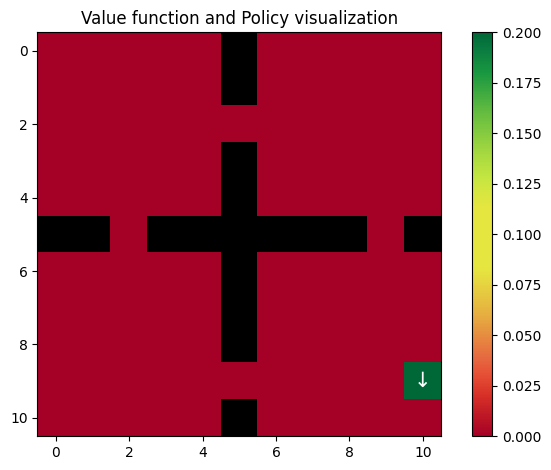

Best Q and action after episode 1:


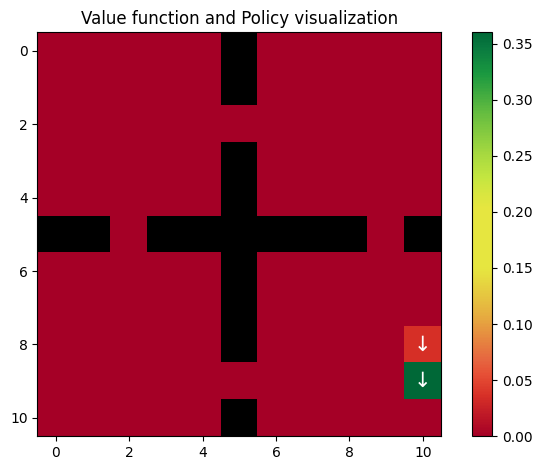

Best Q and action after episode 3:


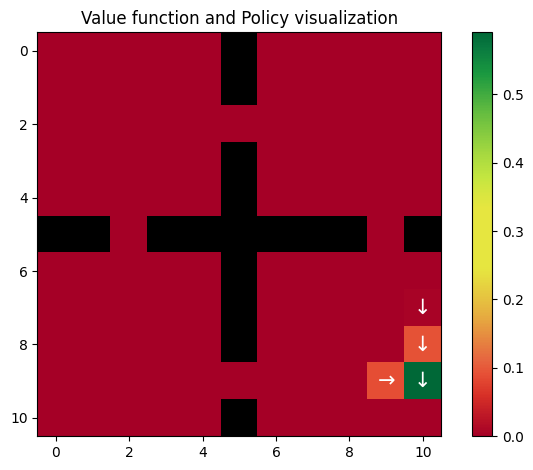

Best Q and action after episode 5:


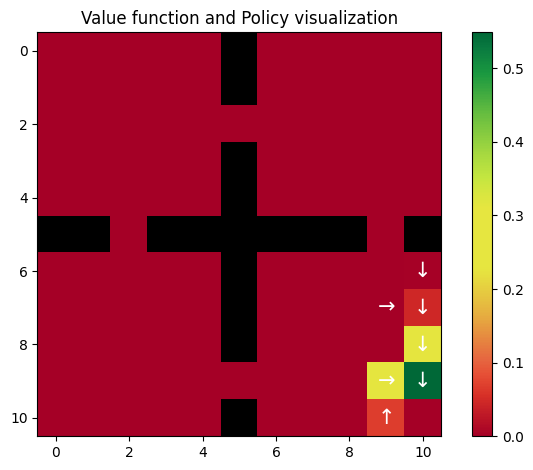

Best Q and action after episode 10:


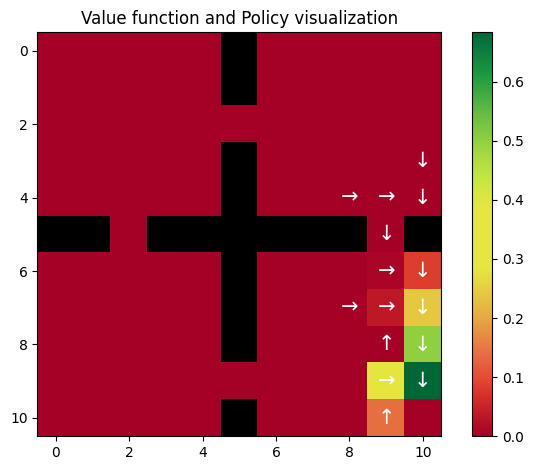

Best Q and action after episode 100:


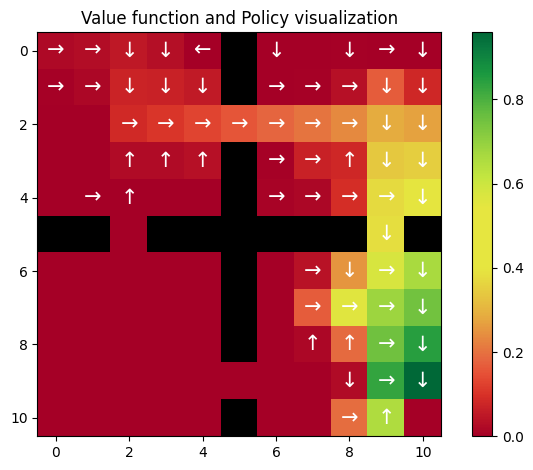

Best Q and action after episode 500:


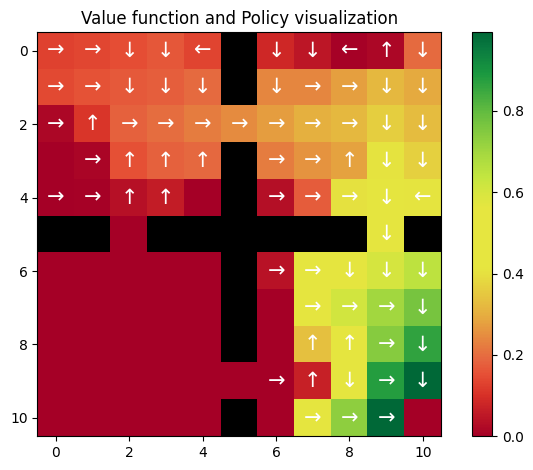

Final Q and policy:


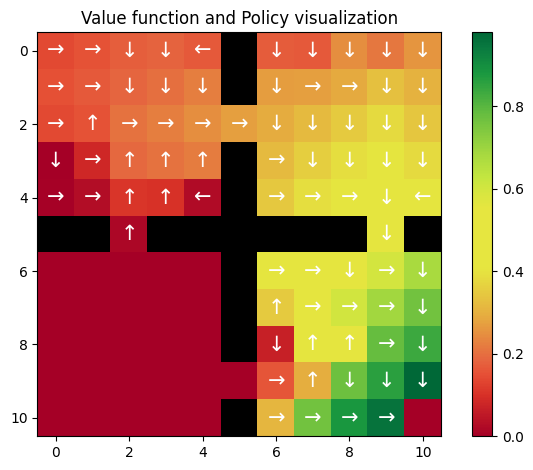

In [187]:
d = {
    'env_shapes': env.shapes,
    'epsilon': 0.2,
    'alpha' : 0.2,
    'gamma': env.gamma,
}
agent = QLearning(**d)
perf_ql = view_train_agent(agent, env, 2000)

Let's compare the number of steps needed to reach the goal during learning. 

Since a lot of randomness is now involved in the process, and different random seeds might lead to vastly different performances, we will now average over $n_s=100$ random seeds to obtain an estimate of the average performance.

If your python setup and PC support the `parallel_` function, feel free to use it to speed the computation up by a factor of around 2. It was quite lazy programming, so be careful not to have too much stuff open or it might crash; sorry about that. Otherwise, use the `multiple_train_agent` function below to run each agent over multiple seeds.

In [171]:
import time
def multiple_train_agent(agent, env, n_episodes, n_s, out_reward=False):
    init = time.time()
    perfs = np.empty((n_s, n_episodes))
    for i in range(n_s):
        perfs[i] = view_train_agent(agent, env, n_episodes, plot=False)
    end = time.time()
    print("Done in {}s".format(end-init))
    return np.mean(perfs, 0)

from multiprocess import Pool
def single_process(agent, env, n_episodes, n_s, n_p):
    out = []
    for i in range(n_s//n_p):
        out.append(view_train_agent(agent, env, n_episodes, plot=False))
    return out

def parallel_multiple_train_agent(agent, env, n_episodes, n_s, out_reward=False):
    init = time.time()
    n_p = 5
    with Pool(n_p) as p:
        outs = p.starmap(single_process, [[agent, env, n_episodes, n_s, n_p]]*n_p)
    outs = np.concatenate(outs, 0)
    end = time.time()
    print("Done in {}s".format(end-init))
    return np.mean(outs, 0)

In [172]:
def make_plot(l, suptitle, title, xlabel, ylabel,
              labels=None, interval_yaxis=None, colors=None, alphas=None):
    """ Simply saves a plot with multiple usual arguments."""
    n = len(labels)
    if colors is None:
        colors = [None]*n
    if alphas is None:
        alphas = [None]*n
    for perf, label, color, alpha in zip(l, labels, colors, alphas):
        plt.plot(perf, label=label, color=color, alpha=alpha)
    plt.legend()

    plt.suptitle(suptitle, fontsize=14, fontweight='bold')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if interval_yaxis is not None:
        new_y1, new_y2 = interval_yaxis
        x1,x2,y1,y2 = plt.axis()
        plt.axis((x1,x2,new_y1,new_y2))

    plt.plot()

Now testing all agents! The runs should take less than a minute.

In [173]:
n_episodes = 1000
n_s = 100
d['epsilon'] = 0.1

In [174]:
# Monte Carlo:
agent = EGMonteCarlo(**d)
perf_mc = parallel_multiple_train_agent(agent, env, n_episodes, n_s)

Done in 4.3517539501190186s


In [90]:
# SARSA:
agent = SARSA(**d)
perf_sarsa = parallel_multiple_train_agent(agent, env, n_episodes, n_s)

Done in 4.79536509513855s


In [91]:
# QLearning:
agent = QLearning(**d)
perf_ql = parallel_multiple_train_agent(agent, env, n_episodes, n_s)

Done in 4.310938835144043s


In [92]:
# DoubleQLearning:
agent = DoubleQLearning(**d)
perf_dql = parallel_multiple_train_agent(agent, env, n_episodes, n_s)

Done in 4.80793309211731s


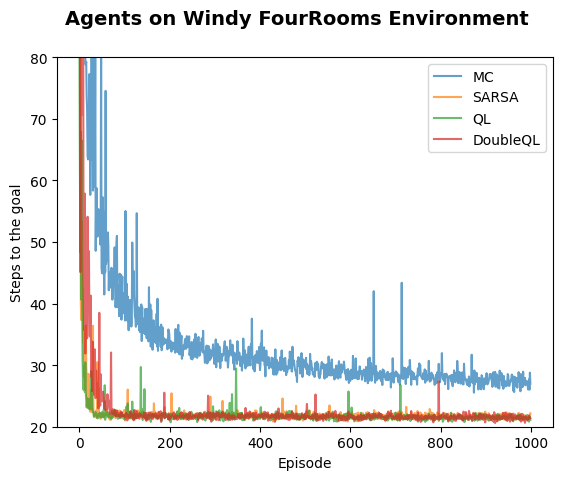

In [93]:
make_plot([perf_mc, perf_sarsa, perf_ql, perf_dql], 
          suptitle="Agents on Windy FourRooms Environment", title=None,
          xlabel="Episode", ylabel="Steps to the goal", 
          labels=['MC', 'SARSA', 'QL', "DoubleQL"], interval_yaxis=(20,80),
          alphas=[0.7]*4)

<span style="color:red"> **TODO** </span>: **Interpret** briefly your results; try to explain the main differences you observe.

The first thing that is visible on the graph is that Monte Carlo method performs significantly worse than others. It requires more episodes to reduce steps required to reach the goal. The reason behind that is the fact that it explores more and it doesn't use action values for policy evaluation. We can also notice that the rest algorithms have quite similar performance. Double QLearning at the beginning works slightly worse it is because of the fact that it uses two Q matrices. Thereore, it needs more episodes to update them. Sarsa and QLearning follows very similar trend even though they have slightly different approaches. I expected that QLearning would be slightly better as it uses greedy action for updates of Q matrices.

## 5. <span style="color:green"> (2 point) </span>  <span style="color:blue"> **TODO** </span> Playground
Because QLearning learns the optimal value function and tends to learn an optimal policy faster than SARSA, it is most used in research. In this section, play around with the hyperparameters and design choices of QLearning. 

<span style="color:red"> **TODO** </span> For each hyperparameter or setting you play with, create a new subsection using `###` in markdown. Present your results in plots similar to the one above, comparing values and choices. Each curve should be averaged over $n_s=100$ seeds, to make for reliable graphs. Explain your experiments and analyze your results for each section. If you're testing an interesting value or new hyperparameter, try to also visualize what it changes using the `view_train_agent` function. 

### Play with epsilon values

Done in 8.38646125793457s
Done in 14.373626947402954s
Done in 10.937489032745361s
Done in 11.918920755386353s


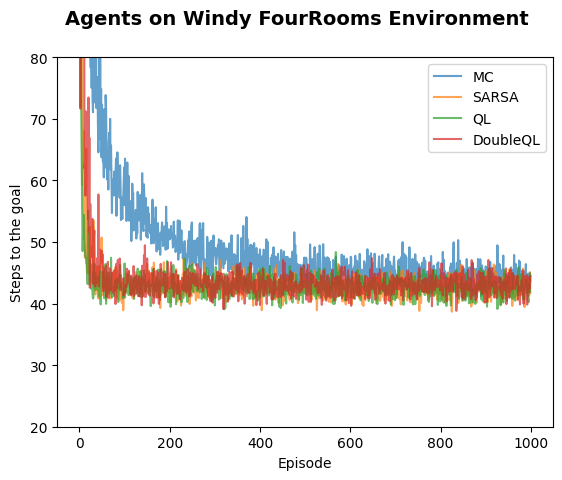

In [188]:
d_eps = d.copy()
d_eps['epsilon'] = 0.5
# Monte Carlo:
agent = EGMonteCarlo(**d_eps)
perf_mc = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
# SARSA:
agent = SARSA(**d_eps)
perf_sarsa = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
# QLearning:
agent = QLearning(**d_eps)
perf_ql = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
# DoubleQLearning:
agent = DoubleQLearning(**d_eps)
perf_dql = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
make_plot([perf_mc, perf_sarsa, perf_ql, perf_dql], 
          suptitle="Agents on Windy FourRooms Environment", title=None,
          xlabel="Episode", ylabel="Steps to the goal", 
          labels=['MC', 'SARSA', 'QL', "DoubleQL"], interval_yaxis=(20,80),
          alphas=[0.7]*4)

Done in 4.815562963485718s
Done in 5.098818778991699s
Done in 4.66963005065918s
Done in 5.151201963424683s


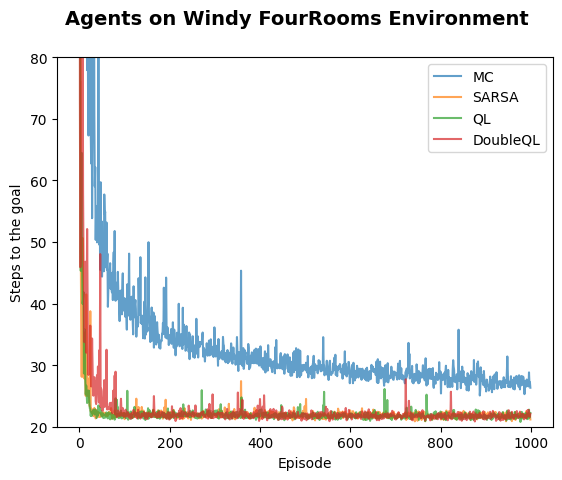

In [189]:
d_eps['epsilon'] = 0.1

# Monte Carlo:
agent = EGMonteCarlo(**d_eps)
perf_mc = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
# SARSA:
agent = SARSA(**d_eps)
perf_sarsa = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
# QLearning:
agent = QLearning(**d_eps)
perf_ql = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
# DoubleQLearning:
agent = DoubleQLearning(**d_eps)
perf_dql = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
make_plot([perf_mc, perf_sarsa, perf_ql, perf_dql], 
          suptitle="Agents on Windy FourRooms Environment", title=None,
          xlabel="Episode", ylabel="Steps to the goal", 
          labels=['MC', 'SARSA', 'QL', "DoubleQL"], interval_yaxis=(20,80),
          alphas=[0.7]*4)

Based on the plots we can notice that by changing epsilon parameter the algorithms converge to different number of steps required to reach the goal. Moreover, all of them also have bigger spikes. All these observations are because by playing with epsilon parameter we can control the degree of eploring and exploiting environment. With higher parameter we explore more as there is higher probability to choose random action. The other interesting observation is that Monte Carlo in the first case coverges than to the same number of steps as other algorithms than in the second case. In the first case we can notice that at 600th epsiode all algorithms follows the same trend. 

### Playing with alpha values

Done in 5.020559072494507s
Done in 8.969359874725342s
Done in 5.694849014282227s
Done in 7.652545928955078s


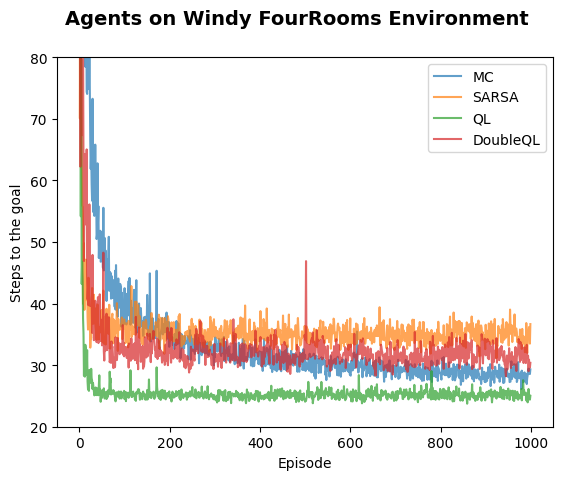

In [190]:
d_alpha = d.copy()
d_alpha['alpha'] = 0.8
# Monte Carlo:
agent = EGMonteCarlo(**d_alpha)
perf_mc = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
# SARSA:
agent = SARSA(**d_alpha)
perf_sarsa = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
# QLearning:
agent = QLearning(**d_alpha)
perf_ql = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
# DoubleQLearning:
agent = DoubleQLearning(**d_alpha)
perf_dql = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
make_plot([perf_mc, perf_sarsa, perf_ql, perf_dql], 
          suptitle="Agents on Windy FourRooms Environment", title=None,
          xlabel="Episode", ylabel="Steps to the goal", 
          labels=['MC', 'SARSA', 'QL', "DoubleQL"], interval_yaxis=(20,80),
          alphas=[0.7]*4)

Done in 5.309847116470337s
Done in 6.6923840045928955s
Done in 6.018902063369751s
Done in 6.770498037338257s


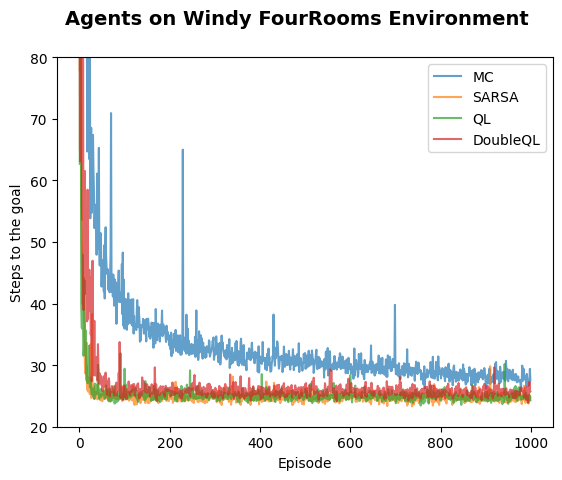

In [191]:
d_alpha['alpha'] = 0.1
# Monte Carlo:
agent = EGMonteCarlo(**d_alpha)
perf_mc = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
# SARSA:
agent = SARSA(**d_alpha)
perf_sarsa = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
# QLearning:
agent = QLearning(**d_alpha)
perf_ql = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
# DoubleQLearning:
agent = DoubleQLearning(**d_alpha)
perf_dql = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
make_plot([perf_mc, perf_sarsa, perf_ql, perf_dql], 
          suptitle="Agents on Windy FourRooms Environment", title=None,
          xlabel="Episode", ylabel="Steps to the goal", 
          labels=['MC', 'SARSA', 'QL', "DoubleQL"], interval_yaxis=(20,80),
          alphas=[0.7]*4)

As alpha parameter is responsible for learning degree it was expected that algorithm would converge quicker as we increase it. However, results contradict these expectations. In the first example I used extreme example as I set up 0.8 as an alpha parameter. This setting made worse performance for Double QLearning and Sarsa algorithms. They have even worse performance than Monte Carlo method. They also have higher spikes. The surprising thing is that for QLearning it didnt't have ane major impact.

### Playing with gamma

Done in 5.0903849601745605s
Done in 6.331715106964111s
Done in 5.649187088012695s
Done in 6.142269849777222s


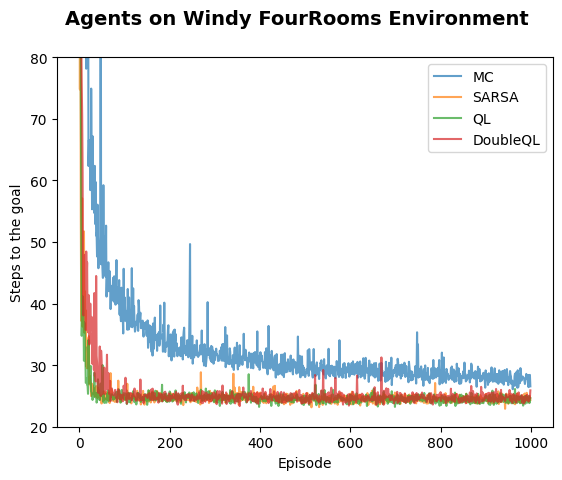

In [192]:
d_gamma = d.copy()
d_gamma['gamma'] = 0.9
# Monte Carlo:
agent = EGMonteCarlo(**d_gamma)
perf_mc = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
# SARSA:
agent = SARSA(**d_gamma)
perf_sarsa = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
# QLearning:
agent = QLearning(**d_gamma)
perf_ql = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
# DoubleQLearning:
agent = DoubleQLearning(**d_gamma)
perf_dql = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
make_plot([perf_mc, perf_sarsa, perf_ql, perf_dql], 
          suptitle="Agents on Windy FourRooms Environment", title=None,
          xlabel="Episode", ylabel="Steps to the goal", 
          labels=['MC', 'SARSA', 'QL', "DoubleQL"], interval_yaxis=(20,80),
          alphas=[0.7]*4)

Done in 4.574124097824097s
Done in 6.603551864624023s
Done in 5.603449821472168s
Done in 6.344735860824585s


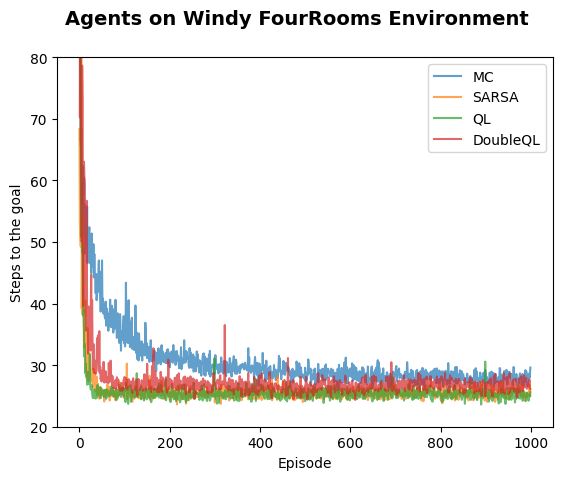

In [193]:
d_gamma = d
d_gamma['gamma'] = 0.1
# Monte Carlo:
agent = EGMonteCarlo(**d_gamma)
perf_mc = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
# SARSA:
agent = SARSA(**d_gamma)
perf_sarsa = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
# QLearning:
agent = QLearning(**d_gamma)
perf_ql = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
# DoubleQLearning:
agent = DoubleQLearning(**d_gamma)
perf_dql = parallel_multiple_train_agent(agent, env, n_episodes, n_s)
make_plot([perf_mc, perf_sarsa, perf_ql, perf_dql], 
          suptitle="Agents on Windy FourRooms Environment", title=None,
          xlabel="Episode", ylabel="Steps to the goal", 
          labels=['MC', 'SARSA', 'QL', "DoubleQL"], interval_yaxis=(20,80),
          alphas=[0.7]*4)

Theoretically gamma parameter is responsible for discounting future values. I provided here two extreme examples and we cannot see any major differences in performance. The only slight change is visible in the MC method. Its performance is slightly better when gamma was lower.